In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Read the dataset using pandas
df = pd.read_csv('test_set_VU_DM.csv')

In [3]:
df_copy = df.copy()
df = df_copy.copy()

In [4]:
df = df.drop(['random_bool', 'date_time'], axis=1)

#### Data quality

In [5]:
# Extreme values - price usd
# Set every value above 10k to missing
df.loc[df['price_usd'] > 10000, 'price_usd'] = np.nan

In [6]:
# Recode - prop_log_historical_price: replace 0 with missing, since 0 is basically missing in this case
df['prop_log_historical_price'] = df['prop_log_historical_price'].replace(0, np.nan)

#### Remove or recode highly missing features

In [7]:
# New variables - diff
df["starrating_diff"] = abs(df["visitor_hist_starrating"] - df["prop_starrating"])
df["usd_diff"] = abs(df["visitor_hist_adr_usd"] - df["price_usd"])

In [8]:
# removing missings with >80% missings
df = df.drop(['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score'], axis=1)

In [9]:
# transforming competitor data to reduce missings
df['avg_comp_rate'] = df[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']].mean(axis=1)
df['avg_comp_inv'] = df[['comp1_inv', 'comp2_inv', 'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 'comp8_inv']].mean(axis=1)
df['avg_comp_ratediff'] = df[['comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 
'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']].mean(axis=1)

df = df.drop(['comp1_rate', "comp1_inv", 'comp2_rate', "comp2_inv", 'comp3_rate', "comp3_inv", 'comp4_rate', "comp4_inv", 'comp5_rate', "comp5_inv", 'comp6_rate', "comp6_inv", 'comp7_rate', "comp7_inv", 'comp8_rate', "comp8_inv",
              'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff'], axis = 1)


In [10]:
# avg_comp_ratediff is still very highly missing and doesnt really capture anything the other competitor variables dont already capture
# so we remove it
df = df.drop(['avg_comp_ratediff'], axis=1)

#### Importance of prop missings

In [12]:
# There seems to be some importance in the missings of property features. So we can add a boolean variable to the dataset.
cols = ['prop_review_score', 'prop_location_score2', 'prop_log_historical_price']

# Check if any variable is missing for each row
df['prop_missing_bool'] = df[cols].isnull().any(axis=1).astype(int)

#### Impute missings

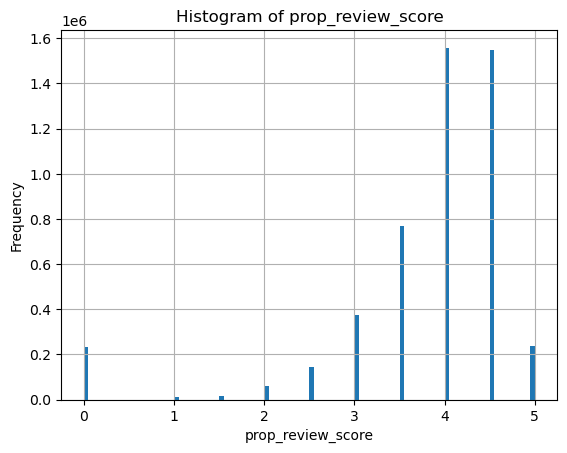

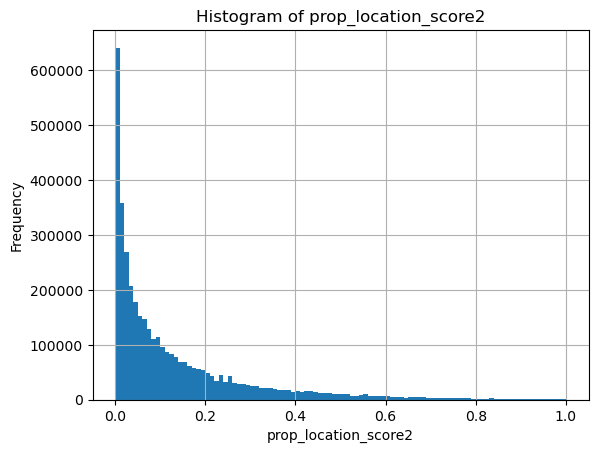

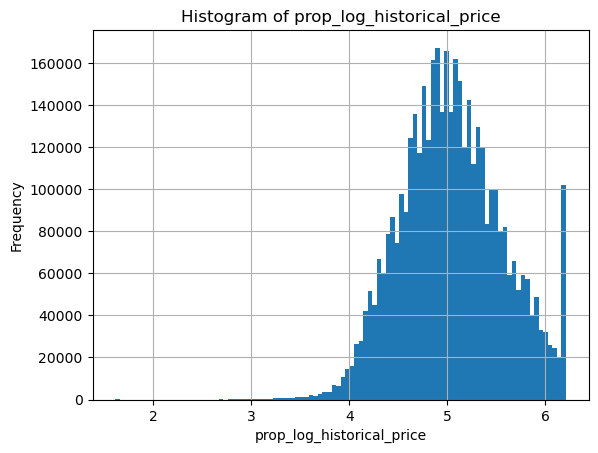

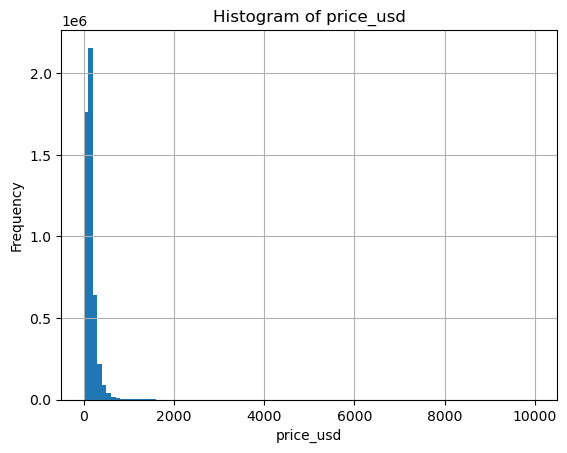

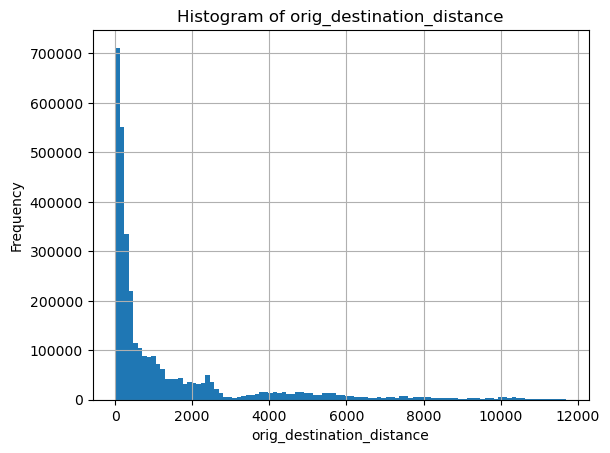

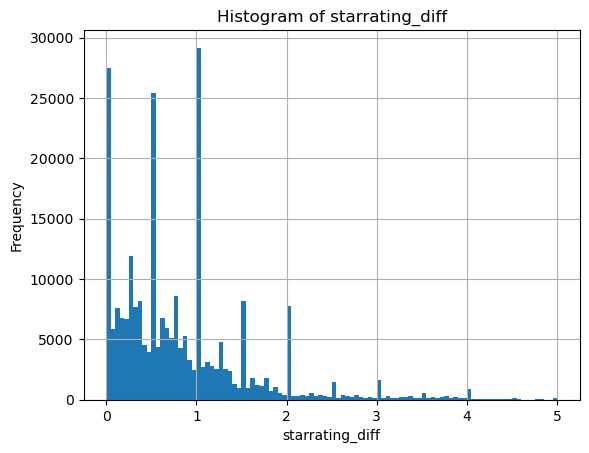

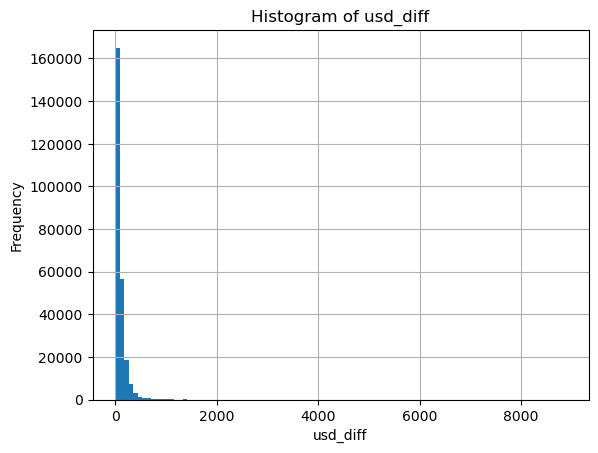

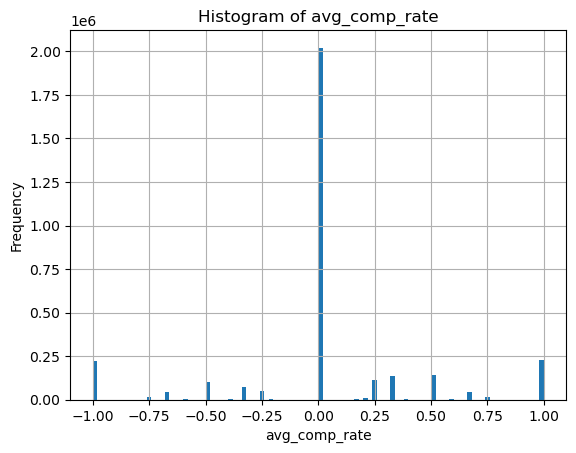

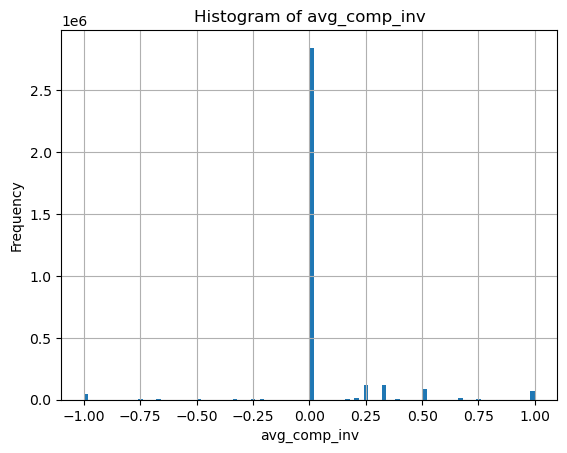

In [13]:
# impute missings based on distribution
# Select columns with missing values
cols_with_missing = df.columns[df.isnull().any()].tolist()

# Loop through columns to plot
for col in df[cols_with_missing]:
    plt.figure()
    df[col].hist(bins=100)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

In [14]:
# orig_destination_distance: impute based on average of 'orig_destination_distance' per combination of country_id and visitor_location_country_id
# Calculate the average per combination of country_id and visitor_location_country_id
average_distance = df.groupby(['prop_country_id', 'visitor_location_country_id'])['orig_destination_distance'].transform('mean')
df['orig_destination_distance'] = df['orig_destination_distance'].fillna(average_distance) # Impute missing values with the average distance

# Replace missings with corresponding medians. 
df[['prop_review_score', 'prop_log_historical_price', 'price_usd']] = df[['prop_review_score', 'prop_log_historical_price', 'price_usd']].fillna(df[['prop_review_score', 'prop_log_historical_price', 'price_usd']].median())

# Replace missings with minimum. Note orig_destination_distance still had some missings, so we impute the rest based on minimum
df[['prop_location_score2', 'orig_destination_distance']] = df[['prop_location_score2', 'orig_destination_distance']].fillna(df[['prop_location_score2', 'orig_destination_distance']].min())

# Replace missings with zero. 
df[['avg_comp_rate','avg_comp_inv']] = df[['avg_comp_rate','avg_comp_inv']].replace(np.nan, 0)

In [15]:
# get dummies for usd_diff, starrating_diff
dummy_cols = dummy_cols = ['starrating_diff', 'usd_diff']
# Loop through selected columns and apply binning
for col in dummy_cols:
    bins = [-np.inf, df[col].quantile(0.50), np.inf]
    labels = ['low', 'high']
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=dummy_cols, dummy_na=True)

In [16]:
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,orig_destination_distance,avg_comp_rate,avg_comp_inv,prop_missing_bool,starrating_diff_low,starrating_diff_high,starrating_diff_nan,usd_diff_low,usd_diff_high,usd_diff_nan
0,1,24,216,219,3180,3,4.5,1,2.94,0.0691,...,0.01,0.0,0.0,0,0,0,1,0,0,1
1,1,24,216,219,5543,3,4.5,1,2.64,0.0843,...,0.01,0.0,0.0,0,0,0,1,0,0,1
2,1,24,216,219,14142,2,3.5,1,2.71,0.0556,...,0.01,0.5,0.0,0,0,0,1,0,0,1
3,1,24,216,219,22393,3,4.5,1,2.40,0.0561,...,0.01,0.0,0.0,0,0,0,1,0,0,1
4,1,24,216,219,24194,3,4.5,1,2.94,0.2090,...,0.01,0.0,0.0,0,0,0,1,0,0,1


In [17]:
# No more missings
df.isna().mean() * 100

srch_id                        0.0
site_id                        0.0
visitor_location_country_id    0.0
prop_country_id                0.0
prop_id                        0.0
prop_starrating                0.0
prop_review_score              0.0
prop_brand_bool                0.0
prop_location_score1           0.0
prop_location_score2           0.0
prop_log_historical_price      0.0
price_usd                      0.0
promotion_flag                 0.0
srch_destination_id            0.0
srch_length_of_stay            0.0
srch_booking_window            0.0
srch_adults_count              0.0
srch_children_count            0.0
srch_room_count                0.0
srch_saturday_night_bool       0.0
orig_destination_distance      0.0
avg_comp_rate                  0.0
avg_comp_inv                   0.0
prop_missing_bool              0.0
starrating_diff_low            0.0
starrating_diff_high           0.0
starrating_diff_nan            0.0
usd_diff_low                   0.0
usd_diff_high       

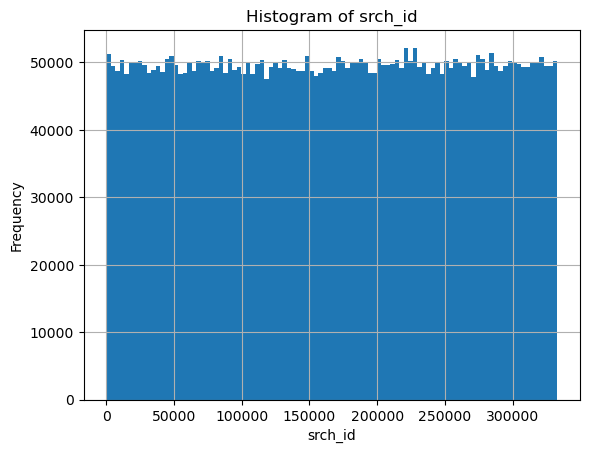

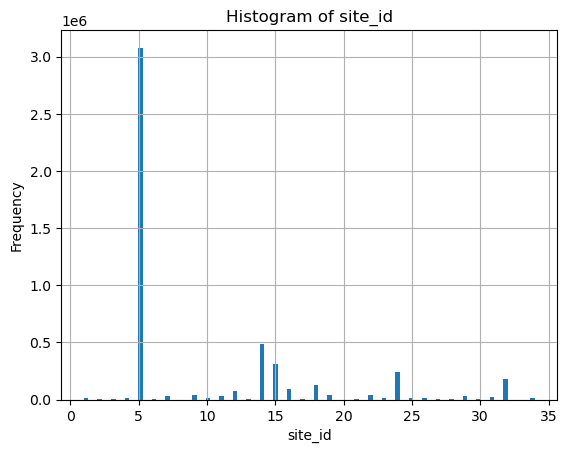

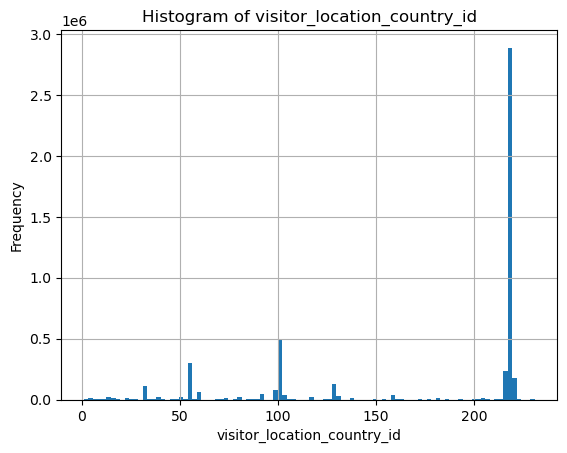

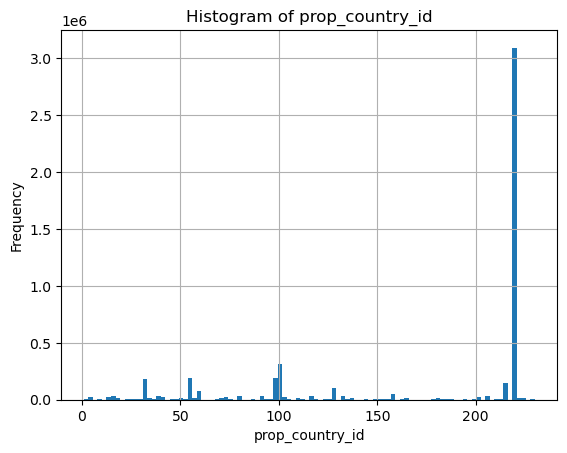

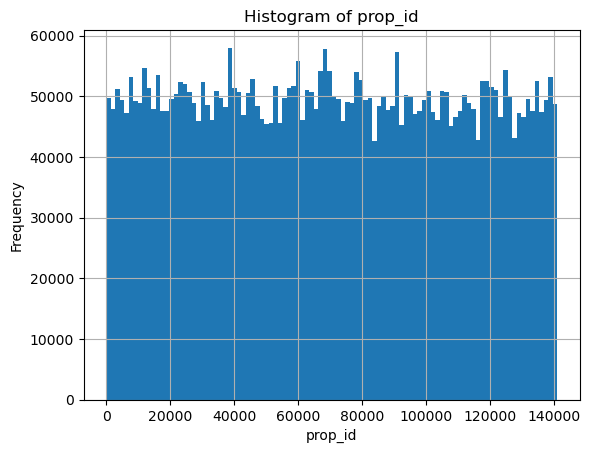

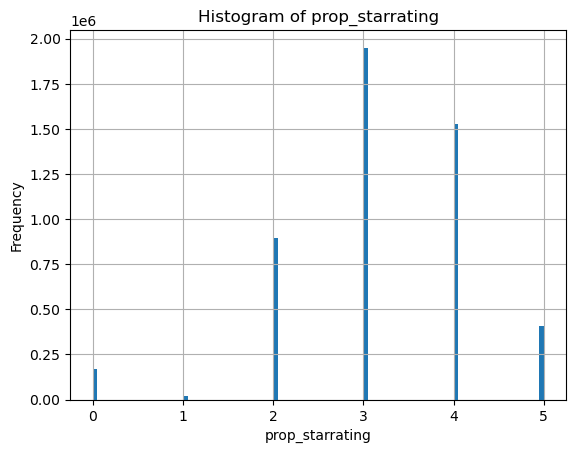

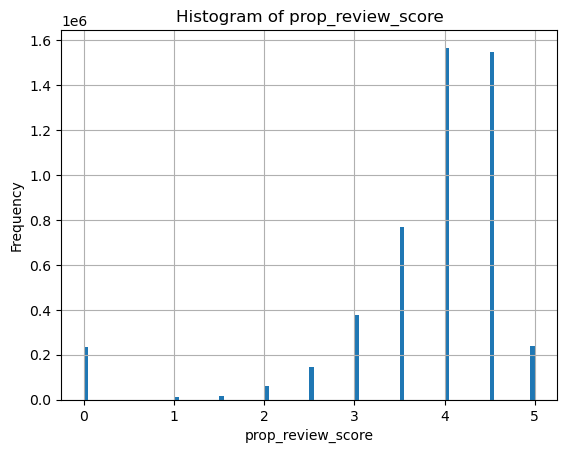

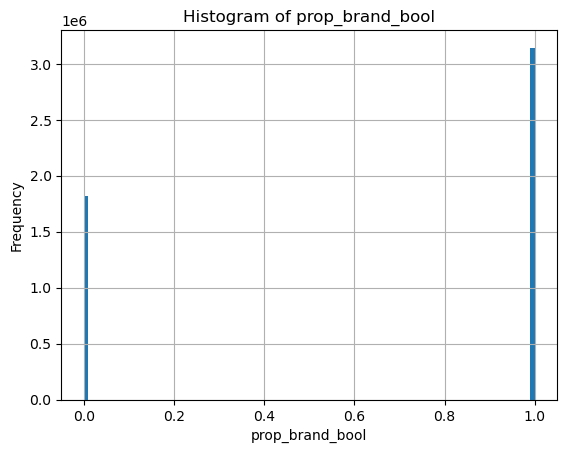

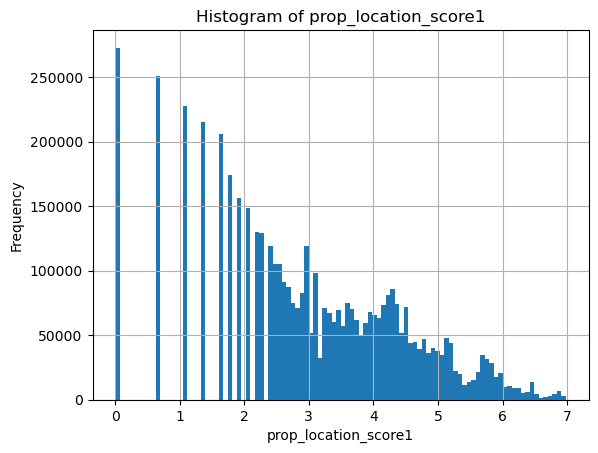

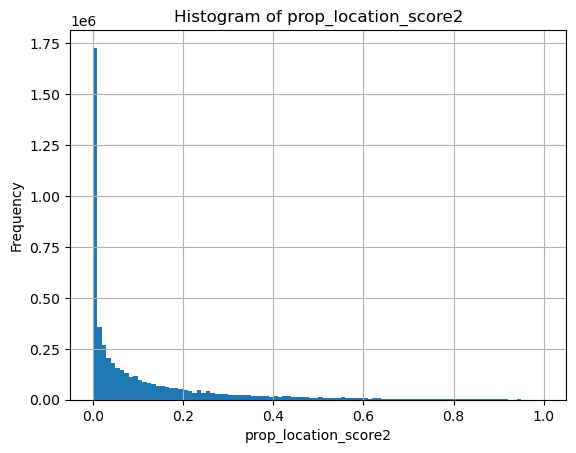

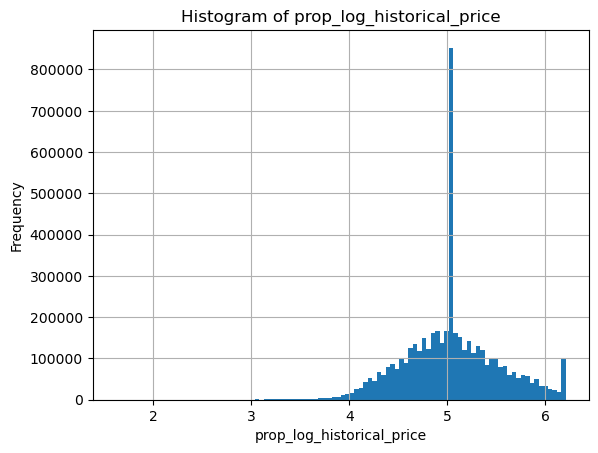

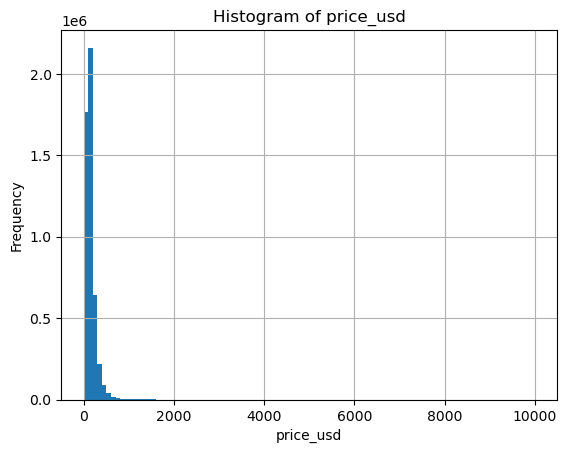

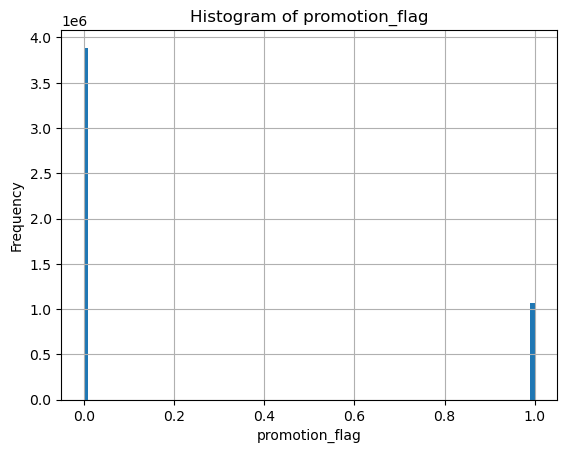

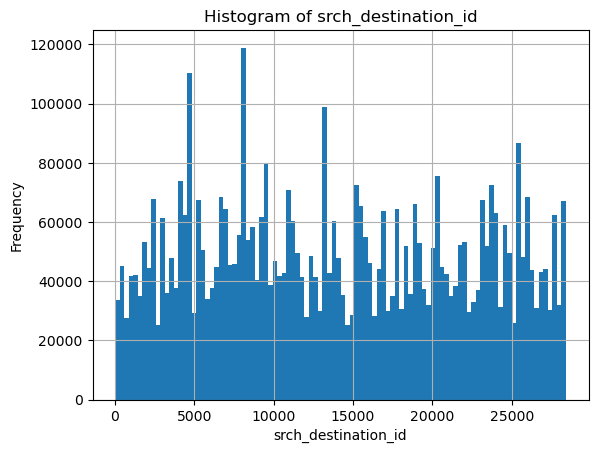

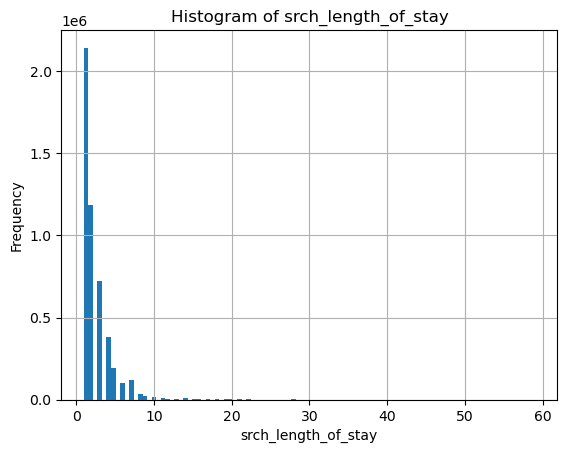

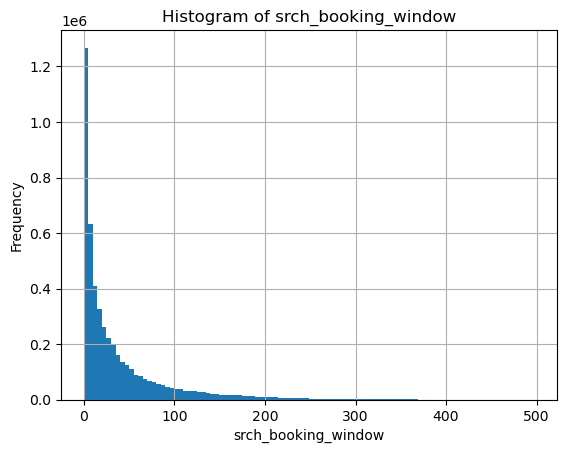

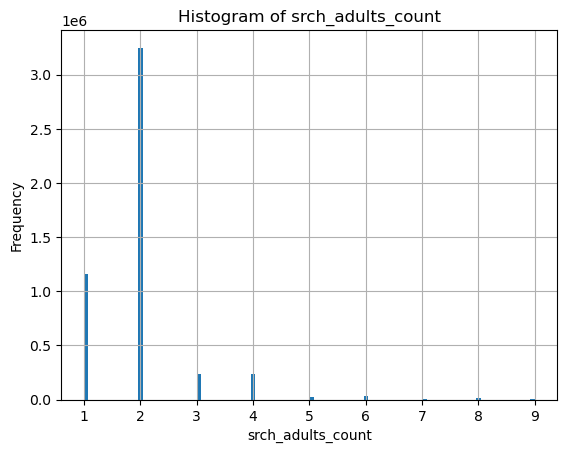

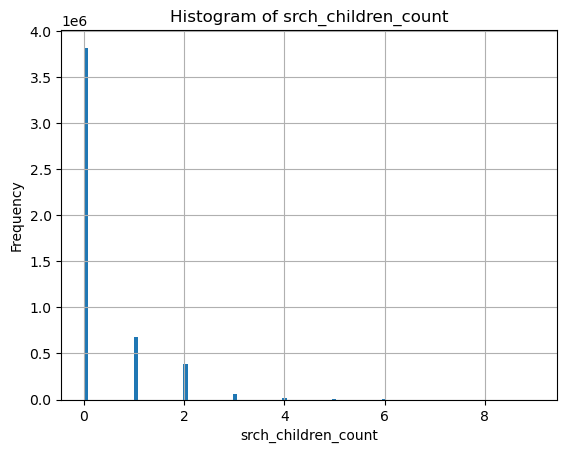

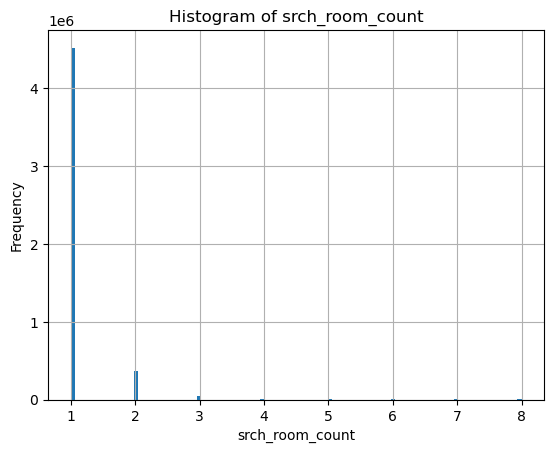

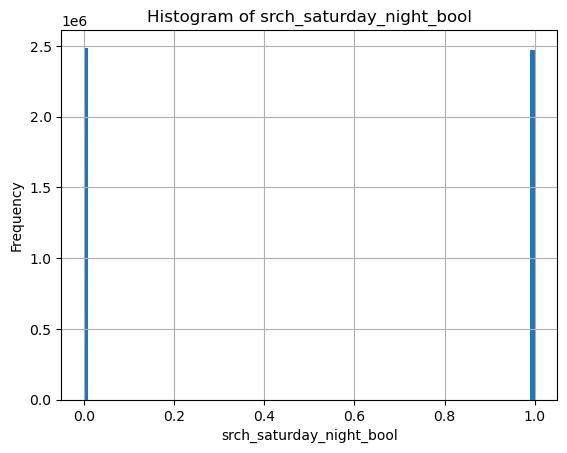

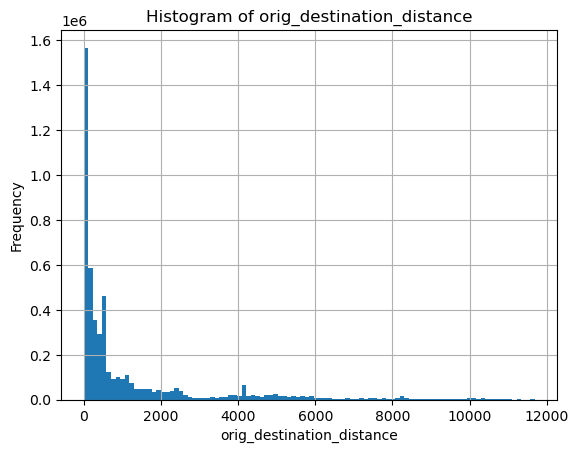

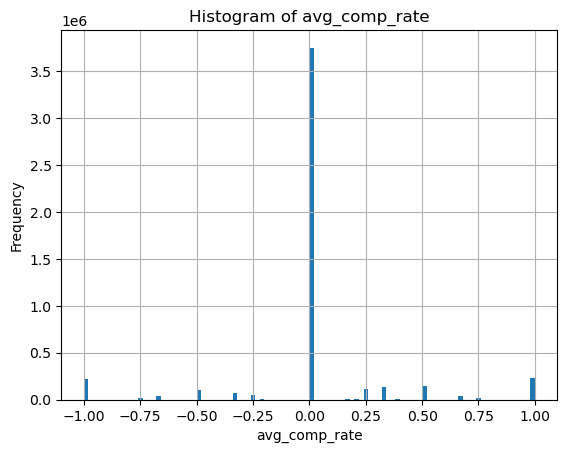

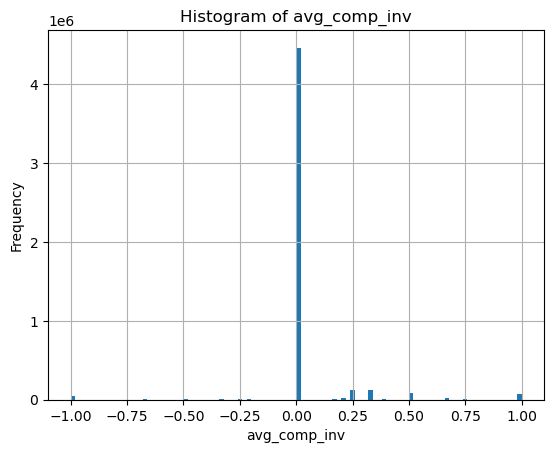

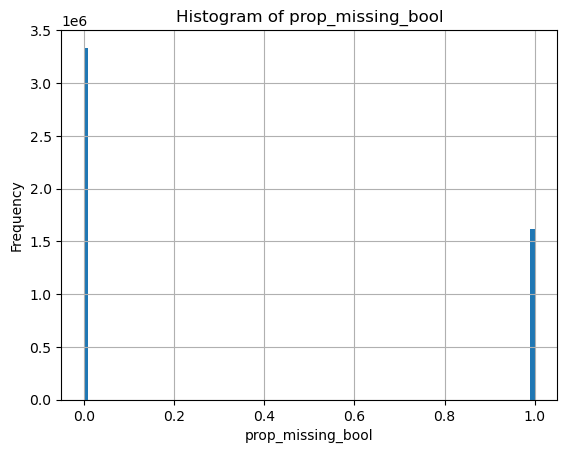

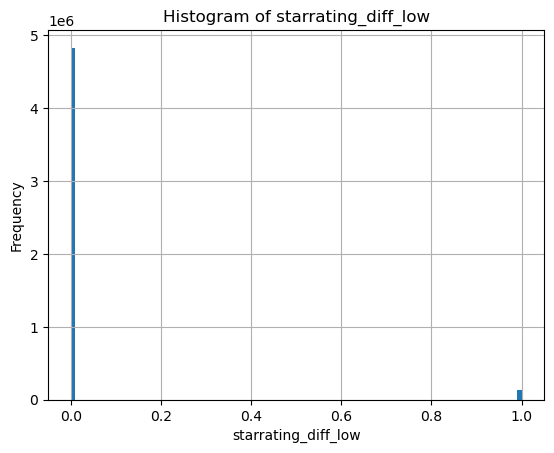

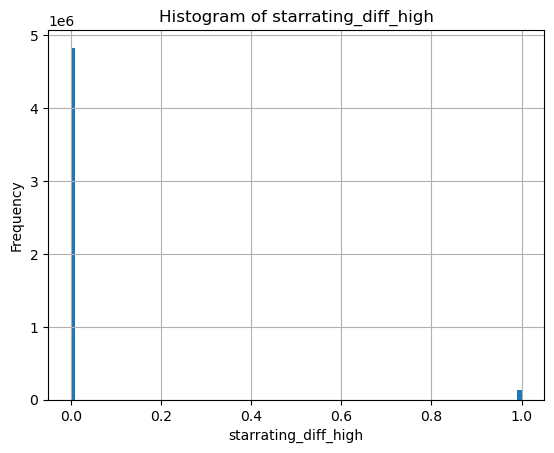

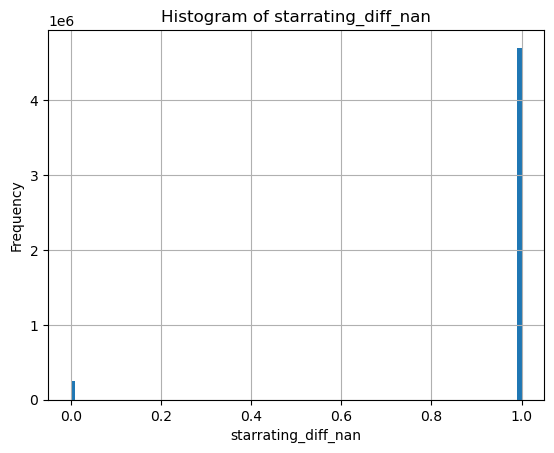

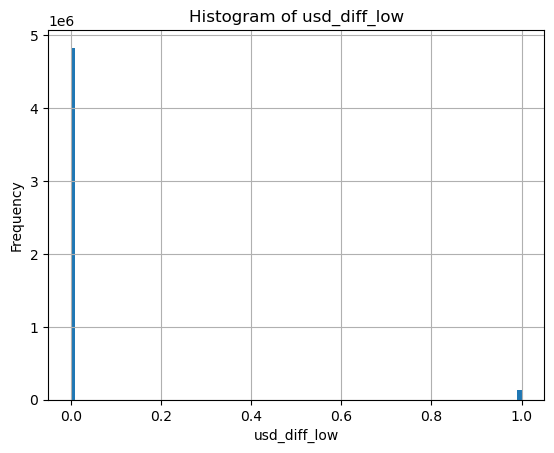

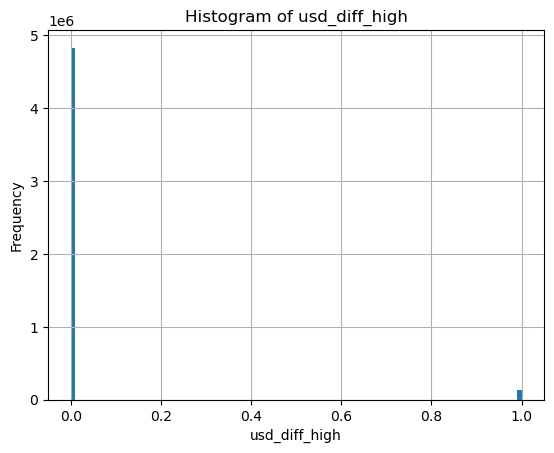

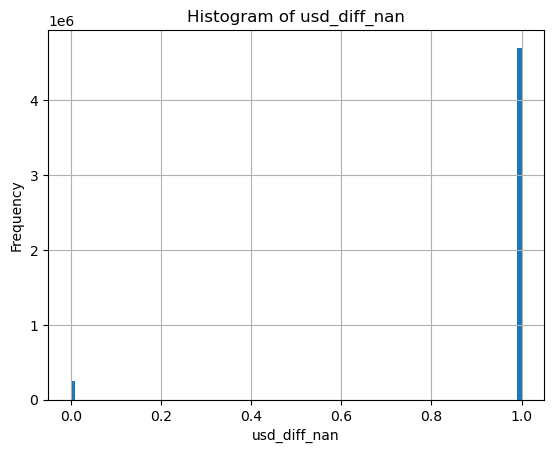

In [18]:
# Distributions look good
# Loop through columns to plot
for col in df.columns:
    if col != 'date_time':
        plt.figure()
        df[col].hist(bins=100)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {col}')
        plt.show()


#### Feature engineering - new features

In [19]:
# average values per property id
columns = ['prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance']

for column in columns:
    new_column_name = f"avg_{column}_propid"
    df[new_column_name] = df.groupby('prop_id')[column].transform('mean')



In [20]:
# Rank_price
# We can create a variable that captures the rank within certain queries based on price and quality.
df['index_queryprice'] = df.groupby('srch_id')['price_usd'].transform(lambda x: x / x.mean())
df.loc[df['index_queryprice'] > 5, 'index_queryprice'] = 5

df['index_destinationprice'] = df.groupby('srch_destination_id')['price_usd'].transform(lambda x: x / x.mean()) 
df.loc[df['index_destinationprice'] > 5, 'index_destinationprice'] = 5

epsilon = 1e-8  # Small constant to avoid division by zero
df['index_queryquality'] = df.groupby('srch_id')['prop_starrating'].transform(lambda x: x / (x.mean() + epsilon))
df.loc[df['index_queryquality'] > 5, 'index_queryquality'] = 5

df['index_queryreview'] = df.groupby('srch_id')['prop_review_score'].transform(lambda x: x / (x.mean() + epsilon))
df.loc[df['index_queryreview'] > 5, 'index_queryreview'] = 5


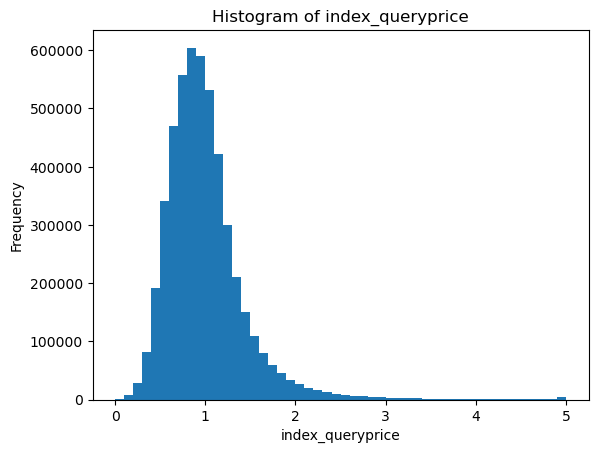

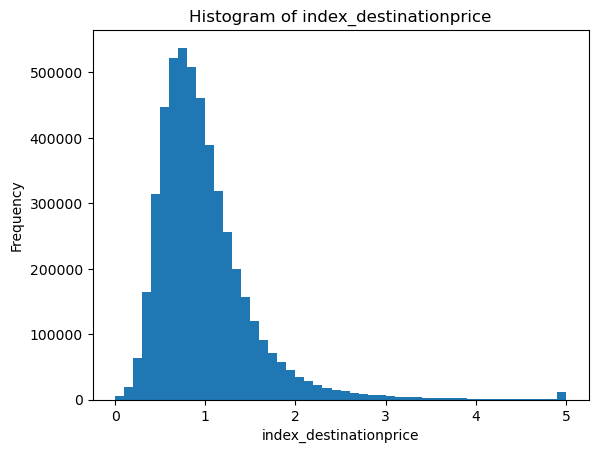

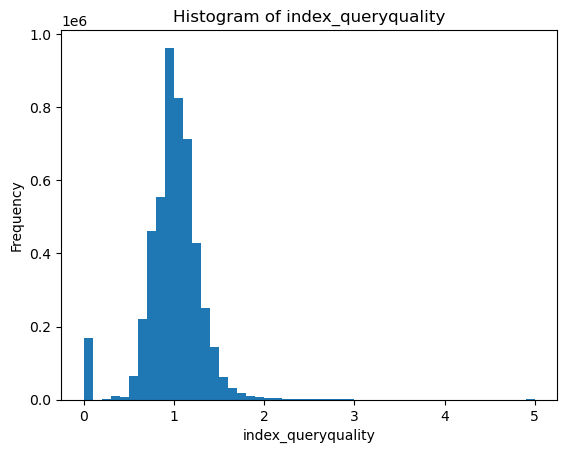

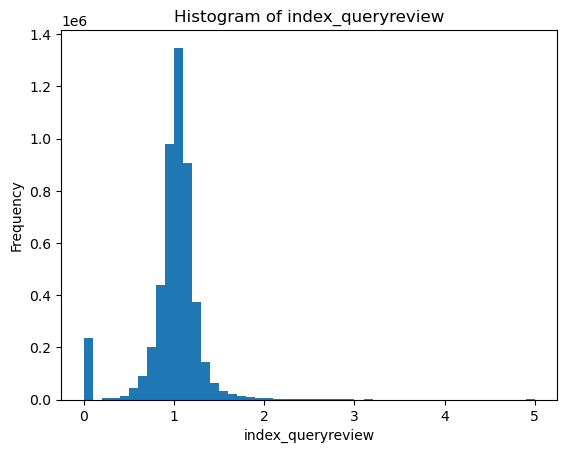

In [21]:
import matplotlib.pyplot as plt

# Plot histogram for 'index_queryprice'
plt.hist(df['index_queryprice'], bins=50)
plt.xlabel('index_queryprice')
plt.ylabel('Frequency')
plt.title('Histogram of index_queryprice')
plt.show()

# Plot histogram for 'index_destinationprice'
plt.hist(df['index_destinationprice'], bins=50)
plt.xlabel('index_destinationprice')
plt.ylabel('Frequency')
plt.title('Histogram of index_destinationprice')
plt.show()

# Plot histogram for 'index_queryreview'
plt.hist(df['index_queryquality'], bins=50)
plt.xlabel('index_queryquality')
plt.ylabel('Frequency')
plt.title('Histogram of index_queryquality')
plt.show()

# Plot histogram for 'index_queryreview'
plt.hist(df['index_queryreview'], bins=50)
plt.xlabel('index_queryreview')
plt.ylabel('Frequency')
plt.title('Histogram of index_queryreview')
plt.show()


In [22]:
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,avg_srch_booking_window_propid,avg_srch_adults_count_propid,avg_srch_children_count_propid,avg_srch_room_count_propid,avg_srch_saturday_night_bool_propid,avg_orig_destination_distance_propid,index_queryprice,index_destinationprice,index_queryquality,index_queryreview
0,1,24,216,219,3180,3,4.5,1,2.94,0.0691,...,22.859459,1.913514,0.356757,1.054054,0.556757,748.315276,1.268703,1.327060,1.115385,1.120172
1,1,24,216,219,5543,3,4.5,1,2.64,0.0843,...,21.563492,2.023810,0.468254,1.067460,0.623016,679.851090,1.258042,1.315909,1.115385,1.120172
2,1,24,216,219,14142,2,3.5,1,2.71,0.0556,...,26.046667,1.886667,0.293333,1.060000,0.466667,777.487393,0.522407,0.546437,0.743590,0.871245
3,1,24,216,219,22393,3,4.5,1,2.40,0.0561,...,25.367347,1.836735,0.238095,1.068027,0.544218,775.836659,1.524576,1.594703,1.115385,1.120172
4,1,24,216,219,24194,3,4.5,1,2.94,0.2090,...,21.859813,1.869159,0.369159,1.060748,0.500000,733.293180,0.842248,0.880990,1.115385,1.120172


#### Feature engineering - data transformation

In [23]:
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Specify the columns to be excluded from normalization
columns_to_exclude = ['srch_id', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'srch_destination_id']

# Get the columns to be normalized by excluding the columns to exclude
columns_to_normalize = [col for col in df.columns if col not in columns_to_exclude]

# Apply Min-Max scaling to the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [24]:
df.describe()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,avg_srch_booking_window_propid,avg_srch_adults_count_propid,avg_srch_children_count_propid,avg_srch_room_count_propid,avg_srch_saturday_night_bool_propid,avg_orig_destination_distance_propid,index_queryprice,index_destinationprice,index_queryquality,index_queryreview
count,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,...,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06,4.959183e+06
mean,1.666460e+05,9.979214e+00,1.752504e+02,1.738371e+02,7.008111e+04,6.365084e-01,7.555907e-01,6.339091e-01,4.125168e-01,1.018317e-01,...,1.049261e-01,1.215696e-01,6.939494e-02,2.221519e-02,4.983002e-01,1.010533e-01,1.997705e-01,1.977366e-01,1.999587e-01,1.999698e-01
std,9.614992e+04,7.667722e+00,6.590284e+01,6.835006e+01,4.061363e+04,2.098715e-01,2.101095e-01,4.817348e-01,2.196512e-01,1.509622e-01,...,5.180002e-02,2.464187e-02,4.260921e-02,1.543719e-02,1.263445e-01,7.143098e-02,8.788194e-02,1.082663e-01,6.100095e-02,6.082114e-02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.331150e+04,5.000000e+00,1.000000e+02,1.000000e+02,3.502100e+04,6.000000e-01,7.000000e-01,0.000000e+00,2.564470e-01,1.400000e-03,...,6.801347e-02,1.072835e-01,4.235294e-02,1.349693e-02,4.315068e-01,5.016602e-02,1.444843e-01,1.288791e-01,1.722222e-01,1.858921e-01
50%,1.670950e+05,5.000000e+00,2.190000e+02,2.190000e+02,6.960700e+04,6.000000e-01,8.000000e-01,1.000000e+00,3.968481e-01,3.560000e-02,...,9.593254e-02,1.216667e-01,6.153846e-02,2.102908e-02,5.014663e-01,7.761852e-02,1.865137e-01,1.758268e-01,2.017391e-01,2.074349e-01
75%,2.499660e+05,1.400000e+01,2.190000e+02,2.190000e+02,1.051790e+05,8.000000e-01,9.000000e-01,1.000000e+00,5.787966e-01,1.379000e-01,...,1.312538e-01,1.357143e-01,8.711656e-02,2.861111e-02,5.781250e-01,1.307670e-01,2.343195e-01,2.379796e-01,2.317757e-01,2.260465e-01
max,3.327870e+05,3.400000e+01,2.310000e+02,2.300000e+02,1.408210e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


#### Feature selection

In [25]:
# Dropping irrelevant features
df = df.drop(['site_id','visitor_location_country_id', 'prop_country_id', 'srch_destination_id'], axis=1)
df.columns

Index(['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'orig_destination_distance', 'avg_comp_rate', 'avg_comp_inv',
       'prop_missing_bool', 'starrating_diff_low', 'starrating_diff_high',
       'starrating_diff_nan', 'usd_diff_low', 'usd_diff_high', 'usd_diff_nan',
       'avg_prop_log_historical_price_propid', 'avg_price_usd_propid',
       'avg_promotion_flag_propid', 'avg_srch_destination_id_propid',
       'avg_srch_length_of_stay_propid', 'avg_srch_booking_window_propid',
       'avg_srch_adults_count_propid', 'avg_srch_children_count_propid',
       'avg_srch_room_count_propid', 'avg_srch_saturday_night_bool_propid',
       'avg_orig_destination_distance_propid', 'ind

In [27]:
df = df.drop(['index_queryreview', 'index_destinationprice', 'avg_promotion_flag_propid',
              'starrating_diff_nan', 'avg_prop_log_historical_price_propid', 'srch_saturday_night_bool',
               'srch_adults_count', 'srch_children_count', 'orig_destination_distance',
               'prop_location_score1', 'prop_log_historical_price', 'starrating_diff_high',
               'usd_diff_high'], axis=1)

In [28]:
df.columns

Index(['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score2', 'price_usd',
       'promotion_flag', 'srch_length_of_stay', 'srch_booking_window',
       'srch_room_count', 'avg_comp_rate', 'avg_comp_inv', 'prop_missing_bool',
       'starrating_diff_low', 'usd_diff_low', 'usd_diff_nan',
       'avg_price_usd_propid', 'avg_srch_destination_id_propid',
       'avg_srch_length_of_stay_propid', 'avg_srch_booking_window_propid',
       'avg_srch_adults_count_propid', 'avg_srch_children_count_propid',
       'avg_srch_room_count_propid', 'avg_srch_saturday_night_bool_propid',
       'avg_orig_destination_distance_propid', 'index_queryprice',
       'index_queryquality'],
      dtype='object')

In [ ]:
df.to_csv('test_optionC.csv', index=False)


In [ ]:
#t  